In [1]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
listings=pd.read_csv("../source/clean/listings_all_ml.csv.gz")

In [3]:
len(listings)

91174

In [4]:
# create training and validation sets
traintest_set=listings.iloc[0:(round(len(listings)*0.9)),:]
validation_set=listings.iloc[(round(len(listings)*0.9)):len(listings),:]

In [5]:
# create x and y variables
X=traintest_set.drop(["SoldPrice"],axis=1)
y=traintest_set["SoldPrice"].values
X_validation=validation_set.drop(["SoldPrice"],axis=1)
y_validation=validation_set["SoldPrice"].values
print(X.shape,y.shape,X_validation.shape,y_validation.shape)

(82057, 554) (82057,) (9117, 554) (9117,)


In [6]:
# scale the predictors
from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler().fit(X)
X_scaled=X_scaler.transform(X)
X_validation_scaled=X_scaler.transform(X_validation)

In [7]:
# using random forest regressor
from sklearn.ensemble import RandomForestRegressor
rfReg=RandomForestRegressor(random_state=31)

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

time_split = TimeSeriesSplit(n_splits=5)
score=cross_val_score(rfReg,X_scaled,y,cv=time_split,scoring="r2",n_jobs=4)
print(score)

[0.63931916 0.61451322 0.70500631 0.66862047 0.67513231]


In [9]:
# use feature importance to select features to include in final model
rfReg.fit(X_scaled,y)

importances = pd.Series(data=rfReg.feature_importances_ , index= X.columns)
importance_sorted=importances.sort_values(ascending=False)

importance_sorted[0:50]

Latitude                          0.153316
Longitude                         0.147456
Bath                              0.138103
Suburb_TOORAK                     0.068987
SoldYear                          0.054869
Bed                               0.050352
SoldMethod_SoldByAuction          0.038926
crime_rate_lga                    0.032758
swimmingpool                      0.025305
SoldDay                           0.024604
Type_ApartmentUnitFlat            0.024050
Car                               0.022225
tenniscourt                       0.021288
offence_count                     0.019508
Floorplan_True                    0.016792
SoldMonth                         0.014908
Type_House                        0.012282
Suburb_EAST MELBOURNE             0.006980
Suburb_MALVERN                    0.006531
Suburb_CANTERBURY                 0.005920
study                             0.005120
Suburb_ARMADALE                   0.004958
Suburb_CLIFTON HILL               0.004247
secureparki

In [10]:
# only select top 20 features
features=importance_sorted[0:20].index.tolist()

X2=traintest_set[features]
X2_validation=validation_set[features]

X2_scaler=StandardScaler().fit(X2)
X2_scaled=X2_scaler.transform(X2)
X2_validation_scaled=X2_scaler.transform(X2_validation)

In [11]:
rfReg2=RandomForestRegressor(random_state=14)
score=cross_val_score(rfReg2,X2_scaled,y,cv=time_split,scoring="r2",n_jobs=4)
print(score)

[0.64755243 0.66646253 0.69142525 0.6740255  0.67371105]


In [12]:
rfReg2.fit(X2_scaled, y)

RandomForestRegressor(random_state=14)

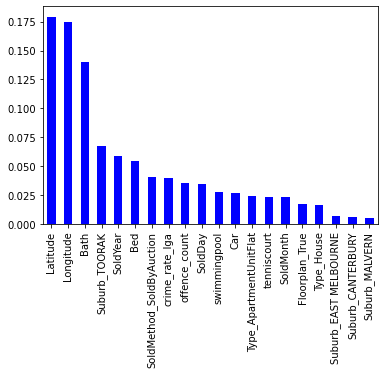

In [13]:
importances = pd.Series(data=rfReg2.feature_importances_ , index= X2.columns)
importance_sorted=importances.sort_values(ascending=False)
importance_sorted.plot(kind="bar", color="blue")

In [14]:
# end up not running randomizedsearchcv because it took too long
from sklearn.model_selection import RandomizedSearchCV
param_grid = { 
    #'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
    'n_estimators': [100,300,500,700,900],
    'max_features': ['auto','sqrt'],
    'max_depth':[None],
    'min_samples_split':[2],
    #'max_depth' : [None,1,2,3,4,5,10,15],
    #'criterion' :['mse','mae'],
    #'min_samples_split':[2,5,10],
    'bootstrap' :[True, False]
}

rf_random = RandomizedSearchCV(estimator=rfReg2,param_distributions=param_grid, 
                               n_iter=200,cv=time_split,verbose=3,random_state=42,n_jobs=-1)

In [15]:
rf_random.fit(X2_scaled,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/yannyinc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 20 is smaller than n_iter=200. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 90.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   estimator=RandomForestRegressor(random_state=14), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2],
                                        'n_estimators': [100, 300, 500, 700,
                                                         900]},
                   random_state=42, verbose=3)

In [16]:
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 700, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
0.6754621204848457


In [17]:
# trying a different model
import xgboost as xgb
xgb_model = xgb.XGBRegressor() 
score=cross_val_score(xgb_model,X2_scaled,y,cv=time_split,scoring="r2",n_jobs=4)
print(score)

[0.60554505 0.63537535 0.73588122 0.67520001 0.69887649]


In [24]:
rf_final=RandomForestRegressor(n_estimators=700,min_samples_split=2,max_features='auto',
                                 max_depth=None,bootstrap=True,random_state=42)
xgb_final=xgb.XGBRegressor(n_estimators=700,random_state=42)

In [25]:
rf_final.fit(X2_scaled,y)
xgb_final.fit(X2_scaled,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scores = pd.DataFrame()
for model in [rf_final,xgb_final]:
    predictions = model.predict(X2_validation_scaled)
    mae = round(mean_absolute_error(y_validation, predictions), 4)
    mse = round(mean_squared_error(y_validation, predictions), 4)
    r2 = round(r2_score(y_validation, predictions), 4)
    m_errors = round(max_error(y_validation, predictions),4)
    exp_variance = round(explained_variance_score(y_validation, predictions),4)
    scores[str(model)] = [mae, mse, r2, m_errors, exp_variance]
scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Max Error', 'Explained Variance']

In [27]:
# both xgb and rf have similar performance, with rf having slightly higher r2 and slightly lower mean squared error
scores.columns=['random forest regression','xgb regressor']
scores

,random forest regression,xgb regressor
Mean Absolute Error,1.393596e+05,1.472166e+05
Mean Squared Error,8.739733e+10,8.858826e+10
R^2,6.847000e-01,6.804000e-01
Max Error,1.282536e+07,1.272317e+07
Explained Variance,6.847000e-01,6.834000e-01


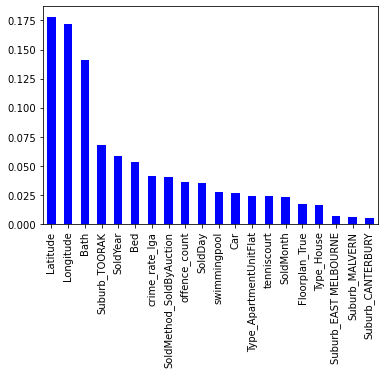

In [28]:
importances = pd.Series(data=rf_final.feature_importances_ , index= X2.columns)
importance_sorted=importances.sort_values(ascending=False)
importance_sorted.plot(kind="bar", color="blue")

In [29]:
# save final model
import joblib
joblib.dump(xgb_final, '../model/xgb_final.sav')
joblib.dump(rf_final, '../model/rf_final.sav',compress=1)
joblib.dump(X2_scaler, '../model/std_scaler.bin', compress=True)

['../model/std_scaler.bin']

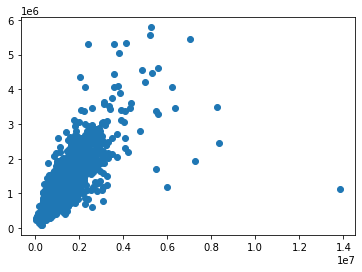

In [21]:
import matplotlib.pyplot as plt
plt.scatter(y_validation, predictions)